In [1]:
import sys
import os
sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

from datetime import datetime
from pymongo.errors import ConnectionFailure
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
from pathlib import Path
from src.utils.imageProcessing import *
from src.utils.utils import *

# Gerar inserts - MongoDB


## Tipos de imagens


Nesta etapa, geramos os inserts para os tipos de imagens suportados no Datawarehouse. Para cada tipo de imagem cadastrado, haverá um nome, uma descrição e metadados, sendo alguns requeridos e outros opcionais.


### DICOM


In [2]:
REQUIRED_DICOM = pd.read_csv("../../outputs/inserts_mongodb/required_dicom.csv")["tag"]
OPTIONAL_DICOM = pd.read_csv("../../outputs/inserts_mongodb/optional_dicom.csv")["tag"]

REQUIRED_DICOM = REQUIRED_DICOM.to_list() + ["pathology"]
OPTIONAL_DICOM = OPTIONAL_DICOM.to_list() + ["bi_rads"]

image_type_dicom = {
    "name": "DICOM",
    "description": "O formato DICOM (Digital Imaging and Communications in Medicine) é um padrão amplamente utilizado"
    "para imagens médicas em ambientes de assistência à saúde. Ele permite o armazenamento, transmissão e"
    "troca de informações médicas, incluindo imagens radiológicas, como radiografias, tomografias,"
    "ressonâncias magnéticas e ultrassonografias, juntamente com dados clínicos associados. O formato"
    "DICOM é altamente reconhecido por sua capacidade de preservar informações cruciais de pacientes e "
    "de imagens médicas, garantindo a interoperabilidade entre diferentes sistemas e dispositivos de "
    "imagem, e desempenha um papel fundamental no diagnóstico, tratamento e gerenciamento de pacientes"
    "em ambientes de saúde.",
    "requiredData": REQUIRED_DICOM,
    "optionalData": OPTIONAL_DICOM,
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

### PGM


In [3]:
image_type_pgm = {
    "name": "PGM",
    "description": "O formato PGM (Portable Gray Map) é um formato de arquivo de imagem que é usado para representar"
    "imagens em tons de cinza (escala de cinza). O PGM é um dos formatos simples e diretos para "
    "armazenar imagens em tons de cinza e é frequentemente usado em processamento de imagens e visão"
    "computacional.",
    "requiredData": ["pathology"],
    "optionalData": ["bi_rads"],
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

### PNG


In [4]:
REQUIRED_PNG = ["pathology"]
OPTIONAL_PNG = ["bi_rads"]

image_type_png = {
    "name": "PNG",
    "description": "Formato de imagem PNG",
    "requiredData": REQUIRED_PNG,
    "optionalData": OPTIONAL_PNG,
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

### JPG


In [5]:
REQUIRED_JPG = ["pathology"]
OPTIONAL_JPG = ["bi_rads"]

image_type_jpg = {
    "name": "JPG",
    "description": "Formato de imagem JPG",
    "requiredData": REQUIRED_JPG,
    "optionalData": OPTIONAL_JPG,
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

## Bancos de imagens de Mamografia


### CBIS-DDSM


In [6]:
# Cria o objeto do banco de dados
database_cbis_ddsm = {
    "name": "CBIS-DDSM",
    "examType": "Mamografia",
    "description": " CBIS-DDSM, ou 'Curated Breast Imaging Subset of DDSM', é um conjunto de dados de"
    "mamografia digital, simplificado e curado, derivado do DDSM original. Com imagens em formato"
    "DICOM e informações associadas, ele é amplamente utilizado na pesquisa de detecção de câncer"
    "de mama, oferecendo uma coleção valiosa para desenvolver algoritmos e técnicas que aprimorem"
    "o diagnóstico e o tratamento dessa importante condição médica.",
    "imageQuality": [],
    "imageType": "DICOM",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\mamografia\\cbis-ddsm",
    "url": "https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []
path_metadata = "../../outputs/mamografia/cbis-ddsm"

list_metadata = load_json(f"{path_metadata}/metadata_calc_case_cbis-ddsm.json")
list_metadata = list_metadata + load_json(
    f"{path_metadata}/metadata_mass_case_cbis-ddsm.json"
)
list_metadata = choices(list_metadata, k=24)

list_metadata_csv = pd.read_csv(
    f"{path_metadata}/metadata_calc_case_cbis-ddsm.csv")
list_metadata_csv = pd.concat(
    [
        list_metadata_csv,
        pd.read_csv(f"{path_metadata}/metadata_mass_case_cbis-ddsm.csv"),
    ]
)

for i, metadata in enumerate(list_metadata):
    metadata_csv = list_metadata_csv[
        list_metadata_csv["image_path"] == metadata["image_path"]
    ]
    database_cbis_ddsm["imageQuality"].append(
        int(metadata["bits_stored (0028, 0101)"]))

    # Extrai dados do csv
    image_path = metadata_csv["image_path"].values[0]
    cropped_image_path = metadata_csv["cropped_image_path"].values[0]
    roi_image_path = metadata_csv["roi_image_path"].values[0]
    pathology = metadata_csv["pathology"].values[0]
    bi_rads = metadata_csv["bi-rads"].values[0]
    patient_id = metadata_csv["id"].values[0]

    # Carrega a imagem e redimensiona
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\cbis-ddsm\\cbis_ddsm_{i}.png"
    image_array = extract_image_dicom(image_path)
    resize_image(
        image_array, (255, 255), save=True, path=resized_image_path, image_type="png"
    )

    resized_image_path = f"/src/assets/teste/cbis-ddsm/cbis_ddsm_{i}.png"
    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "cropped_image_path": cropped_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {
            key: metadata[key] for key in REQUIRED_DICOM if key in metadata.keys()
        },
        "optionalData": {
            key: metadata[key] for key in OPTIONAL_DICOM if key in metadata.keys()
        },
    }

    image["requiredData"]["pathology"] = pathology
    image["optionalData"]["bi_rads"] = str(bi_rads)

    images.append(image)

database_cbis_ddsm["imageQuality"] = list(
    set(database_cbis_ddsm["imageQuality"]))
database_cbis_ddsm["images"] = images

### CMMD


In [7]:
# Cria o objeto do banco de dados
database_cmmd = {
    "name": "CMMD",
    "examType": "Mamografia",
    "description": "O banco de dados CMMD, ou 'The Chinese Mammography Database', é uma coleção de imagens médicas"
    "de mamografias que é utilizada na pesquisa médica, principalmente em estudos relacionados à "
    "detecção precoce de câncer de mama. O CMMD contém imagens de mamografias de pacientes "
    "chineses e é utilizado para uma variedade de aplicações na área de saúde, incluindo o "
    "treinamento de sistemas de inteligência artificial para identificar possíveis anomalias e "
    "ajudar os médicos no diagnóstico de câncer de mama.",
    "imageQuality": [],
    "imageType": "DICOM",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\mamografia\\cmmd",
    "url": "https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70230508",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

# Carrega os metadados
list_metadata = load_json("../../outputs/mamografia/cmmd/metadata_cmmd.json")
list_metadata = choices(list_metadata, k=24)
list_metadata_csv = pd.read_csv(
    "../../outputs/mamografia/cmmd/metadata_cmmd.csv")

for i, metadata in enumerate(list_metadata):
    metadata['image_path'] = metadata['image_path'].replace("/", "\\")
    metadata_csv = list_metadata_csv[
        list_metadata_csv["image_path"] == metadata["image_path"]
    ]
    database_cmmd["imageQuality"].append(
        int(metadata["bits_stored (0028, 0101)"]))

    # Extrai dados do csv
    image_path = metadata_csv["image_path"].values[0]
    pathology = metadata_csv["pathology"].values[0]
    patient_id = metadata_csv["id"].values[0]

    # Carrega a imagem e redimensiona
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\cmmd\\cmmd_{i}.png"
    image_array = extract_image_dicom(image_path)
    resize_image(
        image_array, (255, 255), save=True, path=resized_image_path, image_type="png"
    )

    resized_image_path = f"/src/assets/teste/cmmd/cmmd_{i}.png"
    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {
            key: metadata[key] for key in REQUIRED_DICOM if key in metadata.keys()
        },
        "optionalData": {
            key: metadata[key] for key in OPTIONAL_DICOM if key in metadata.keys()
        },
    }

    image["requiredData"]["pathology"] = pathology

    images.append(image)

database_cmmd["imageQuality"] = list(set(database_cmmd["imageQuality"]))
database_cmmd["images"] = images

### INBREAST


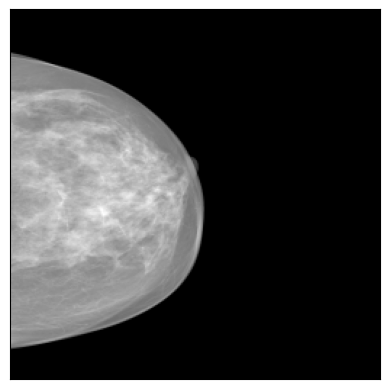

In [8]:
database_inbreast = {
    "name": "INBREAST",
    "examType": "Mamografia",
    "description": "O banco de dados INbreast, originário de Portugal, é uma valiosa coleção de mamografias"
    "digitais e sintéticas, que abrange mamografias de mama saudável e com lesões. Amplamente"
    "utilizado na pesquisa de câncer de mama, fornece informações clínicas detalhadas e é "
    "essencial para o desenvolvimento de algoritmos de diagnóstico e análise de imagens médicas.",
    "imageQuality": [14],
    "imageType": "DICOM",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\mamografia\\inbreast",
    "url": "https://www.kaggle.com/datasets/ramanathansp20/inbreast-dataset",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata = load_json(
    "../../outputs/mamografia/inbreast/metadata_inbreast.json")
list_metadata = choices(list_metadata, k=24)
list_metadata_csv = pd.read_csv(
    "../../outputs/mamografia/inbreast/metadata_inbreast.csv"
)

for i, metadata in enumerate(list_metadata):
    metadata_csv = list_metadata_csv[
        list_metadata_csv["image_path"] == metadata["image_path"]
    ]

    # Extrai dados do csv
    image_path = metadata_csv["image_path"].values[0]
    pathology = "N/A"
    patient_id = str(metadata_csv["id"].values[0])
    bi_rads = metadata_csv["bi-rads"].values[0]
    roi_image_path = metadata_csv["roi_image_path"].values[0]

    # Carrega a imagem e redimensiona
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\inbreast\\inbreast_{i}.png"
    image_array = extract_image_dicom(image_path)
    resized_image = resize_image(
        image_array, (255, 255), save=False, path=resized_image_path, image_type="png"
    )

    im = plt.imshow(resized_image, cmap="gray")
    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])

    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches="tight", pad_inches=0)

    resized_image_path = f"/src/assets/teste/inbreast/inbreast_{i}.png"
    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {
            key: metadata[key] for key in REQUIRED_DICOM if key in metadata.keys()
        },
        "optionalData": {
            key: metadata[key] for key in OPTIONAL_DICOM if key in metadata.keys()
        },
    }

    image["requiredData"]["pathology"] = pathology
    image["optionalData"]["bi_rads"] = str(bi_rads)

    images.append(image)

database_inbreast["imageQuality"] = list(
    set(database_inbreast["imageQuality"]))
database_inbreast["images"] = images

### MIAS


In [9]:
database_mias = {
    "name": "MIAS",
    "examType": "Mamografia",
    "description": "O banco de dados MIAS (Mammographic Image Analysis Society database) é uma coleção essencial"
    "de mamografias digitais usada na pesquisa médica. Com imagens de mamas saudáveis e lesões "
    "indicativas de câncer, juntamente com informações clínicas detalhadas, ele desempenha um papel"
    "vital no desenvolvimento de algoritmos de detecção e diagnóstico de câncer de mama,"
    "contribuindo para avanços no tratamento e cuidados de saúde.",
    "imageQuality": [8],
    "imageType": "PGM",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\mamografia\\mias",
    "url": "http://peipa.essex.ac.uk/info/mias.html",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/mamografia/mias/metadata_mias.csv")
list_metadata_csv = list_metadata_csv.sample(24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    image_path = metadata["image_path"]
    pathology = metadata.get("pathology", "normal")
    patient_id = metadata["id"]
    roi_image_path = metadata.get("roi_image_path", "")

    # Carrega a imagem e redimensiona
    resized_image_path = (
        f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\mias\\mias_{i}.png"
    )
    image_array = cv2.imread(image_path)
    resize_image(
        image_array, (255, 255), save=True, path=resized_image_path, image_type="png"
    )

    resized_image_path = f"/src/assets/teste/mias/mias_{i}.png"
    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {"pathology": pathology},
        "optionalData": {},
    }

    image["requiredData"]["pathology"] = pathology
    images.append(image)
    i += 1

database_mias["images"] = images

## Bancos de imagens de Ultrassom


### BUSI


In [10]:
database_busi = {
    "name": "BUSI",
    "examType": "Ultrassom",
    "description": "O banco de imagens de ultrassom BUSI (Breast Ultrasound Image Set) é uma coleção essencial"
    "de imagens de ultrassom da mama, amplamente utilizada na pesquisa médica para aprimorar a "
    "detecção e diagnóstico do câncer de mama. Ele fornece imagens detalhadas e variadas, "
    "permitindo o desenvolvimento de algoritmos avançados para análise de imagens médicas, "
    "contribuindo assim para avanços no campo da saúde e no combate ao câncer de mama.",
    "imageQuality": [8],
    "imageType": "PNG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\Dataset_BUSI_with_GT",
    "url": "https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/ultrassom/metadata_busi.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    image_path = metadata["image_path"]
    pathology = metadata["pathology"]
    roi_image_path = metadata["roi_image_path"]
    patient_id = metadata["id"]

    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\busi\\busi_{i}.png"
    resized_image = resize_image(
        image_path,
        (255, 255),
        save=True,
        path=resized_image_path,
        image_type="png",
    )

    resized_image_path = f"/src/assets/teste/busi/busi_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_PNG[0]: pathology},
        "optionalData": {},
    }

    images.append(image)
    i += 1
database_busi["images"] = images

### HMSS


In [11]:
database_hmss = {
    "name": "HMSS",
    "examType": "Ultrassom",
    "description": "Banco de imagens de ultrassom HMSS (Hamamatsu Medical School Breast Cancer Dataset)",
    "imageQuality": [8],
    "imageType": "JPG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\HMSS",
    "url": "http://busbench.midalab.net/datasets",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/ultrassom/metadata_hmss.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    image_path = metadata["image_path"]
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\hmss\\hmss_{i}.png"

    resized_image = resize_image(
        image_path,
        (255, 255),
        save=True,
        path=resized_image_path,
        image_type="png",
    )

    resized_image_path = f"/src/assets/teste/hmss/hmss_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_JPG[0]: pathology},
        "optionalData": {},
    }

    images.append(image)
    i += 1

database_hmss["images"] = images

### OASBUD


In [12]:
database_oasbud = {
    "name": "OASBUD",
    "examType": "Ultrassom",
    "description": "Banco de imagens de ultrassom OASBUD",
    "imageQuality": [8],
    "imageType": "PNG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\OASBUD",
    "url": "https://zenodo.org/records/545928",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/ultrassom/metadata_oasbud.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    bi_rads = metadata["bi-rads"]
    image_path = metadata["image_path"]
    roi_image_path = metadata["roi_image_path"]

    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\oasbud\\oasbud_{i}.png"

    resized_image = resize_image(
        image_path,
        (255, 255),
        save=True,
        path=resized_image_path,
        image_type="png",
    )

    resized_image_path = f"/src/assets/teste/oasbud/oasbud_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_PNG[0]: pathology},
        "optionalData": {OPTIONAL_PNG[0]: str(bi_rads)},
    }

    images.append(image)
    i += 1

database_oasbud["images"] = images

### THAMMASAT


In [13]:
database_thammasat = {
    "name": "THAMMASAT",
    "examType": "Ultrassom",
    "description": "Banco de imagens de ultrassom THAMMASAT",
    "imageQuality": [8],
    "imageType": "JPG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\THAMMASAT",
    "url": "https://www.kaggle.com/datasets/fhabibimoghaddam/breast-ultrasound-images",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/ultrassom/metadata_thammasat.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    image_path = metadata["image_path"]

    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\thammasat\\thammasat_{i}.png"

    resized_image = resize_image(
        image_path,
        (255, 255),
        save=True,
        path=resized_image_path,
        image_type="png",
    )

    resized_image_path = f"/src/assets/teste/thammasat/thammasat_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_JPG[0]: pathology},
        "optionalData": {},
    }
    
    images.append(image)
    i += 1

database_thammasat["images"] = images

### UBC


In [14]:
database_ubc = {
    "name": "Ultrassom Breast Classification (UBC)",
    "examType": "Ultrassom",
    "description": "Banco de imagens de ultrassom UBC",
    "imageQuality": [8],
    "imageType": "JPG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\ultrasound_breast_classification",
    "url": "https://www.kaggle.com/datasets/fhabibimoghaddam/breast-ultrasound-images",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/ultrassom/metadata_ultrasound_breast_classification.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    image_path = metadata["image_path"]
    
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\ubc\\ubc_{i}.png"

    resized_image = resize_image(
        image_path,
        (255, 255),
        save=True,
        path=resized_image_path,
        image_type="png",
    )

    resized_image_path = f"/src/assets/teste/ubc/ubc_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_JPG[0]: pathology},
        "optionalData": {},
    }

    images.append(image)
    i+=1
    
database_ubc["images"] = images

## Banco de imagens de Termografia


### DMRI


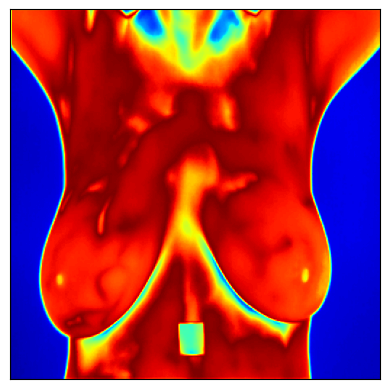

In [15]:
database_dmri = {
    "name": "DMRI",
    "examType": "Termografia",
    "description": "Banco de imagens de termografia DMRI",
    "imageQuality": [8],
    "imageType": "PNG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\termografia\\DMRI_processado",
    "url": "http://visual.ic.uff.br/dmi/",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/termografia/metadata_dmri.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

i = 0
for key, metadata in list_metadata_csv.iterrows():
    image_path = metadata["image_path"]
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\dmri\\dmri_{i}.png"

    resized_image = resize_image(image_path, (255, 255), save=False)

    im = plt.imshow(resized_image, cmap="jet")

    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])

    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches="tight", pad_inches=0)
    resized_image_path = f"/src/assets/teste/dmri/dmri_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "roiPath": roi_image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_PNG[0]: pathology},
        "optionalData": {},
    }

    images.append(image)
    i += 1

database_dmri["images"] = images

### MammoTherm


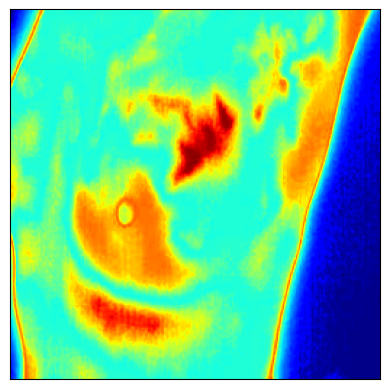

In [16]:
database_mammotherm = {
    "name": "MAMMOTHERM",
    "examType": "Termografia",
    "description": "Banco de imagens de termografia MAMMOTHERM",
    "imageQuality": [8],
    "imageType": "JPG",
    "path": "D:\\mathe\\Documents\\banco_dados_ic\\termografia\\MammoTherm",
    "url": "https://www.mammotherm.org/",
    "createdAt": datetime.now().isoformat(),
    "updatedAt": datetime.now().isoformat(),
}

images = []

list_metadata_csv = pd.read_csv("../../outputs/termografia/metadata_mammotherm.csv")
list_metadata_csv = list_metadata_csv.sample(n=24)

for i, metadata in list_metadata_csv.iterrows():
    image_path = metadata["image_path"]
    patient_id = metadata["id"]
    pathology = metadata["pathology"]
    
    resized_image_path = f"D:\\mathe\\Documents\\banco_dados_ic\\resized_images\\mammotherm\\mammotherm_{i}.png"

    resized_image = resize_image(
        image_path, (255, 255), save=False)

    im = plt.imshow(resized_image, cmap="jet")

    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])

    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches="tight", pad_inches=0)

    resized_image_path = f"/src/assets/teste/mammotherm/mammotherm_{i}.png"

    image = {
        "patientId": patient_id,
        "imagePath": image_path,
        "resizedImagePath": resized_image_path,
        "requiredData": {REQUIRED_JPG[0]: pathology},
        "optionalData": {},
    }

    images.append(image)
    i += 1

database_mammotherm["images"] = images

## Salvar no banco de dados


In [17]:
def get_db(database_name, host: str = "localhost", port: int = 27017):
    """Connecto to mongodb"""
    try:
        connection = MongoClient(host, port)
        return connection[database_name]
    except ConnectionFailure:
        sys.stderr.write("Could not connect to MongoDB")
        sys.exit(1)


image_types = [image_type_dicom, image_type_pgm,
               image_type_png, image_type_jpg]
databases = [
    database_cbis_ddsm,
    database_cmmd,
    database_inbreast,
    database_mias,
    database_busi,
    database_hmss,
    database_oasbud,
    database_thammasat,
    database_ubc,
    database_dmri,
    database_mammotherm
]

save_json("../../outputs/inserts_mongodb/json_raw/image_types.json", image_types)
save_json("../../outputs/inserts_mongodb/json_raw/databases.json", databases)

""" db = get_db('radiomica')
db.databases.insert_many(databases)

db = get_db('radiomica')
db.imagetypes.insert_many(image_types) """

" db = get_db('radiomica')\ndb.databases.insert_many(databases)\n\ndb = get_db('radiomica')\ndb.imagetypes.insert_many(image_types) "